# Modeling

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

crashes_cleaned = pd.read_csv('../data/crashes_cleaned.csv')

In [2]:
!pip install imblearn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


## Using SMOTE to Address Sample Imbalance

In [3]:
from imblearn.over_sampling import SMOTE

le = LabelEncoder()

crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'] = le.fit_transform(crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'])

X = crashes_cleaned.drop(columns = ['CRASH_RECORD_ID', 'Unnamed: 0', 'PRIM_CONTRIBUTORY_CAUSE', 'LONGITUDE', 'LATITUDE', 
                                    'WEATHER_CONDITION_CLEAR', 'ALIGNMENT_STRAIGHT AND LEVEL', 'ROADWAY_SURFACE_COND_SNOW OR SLUSH', 
                                    'ROADWAY_SURFACE_COND_WET', 'ROAD_DEFECT_UNKNOWN', 'MOST_SEVERE_INJURY_NO INDICATION OF INJURY'])
y = crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
ss = StandardScaler()

ss.fit(X_train_resampled)

X_train_scaled = ss.transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

## Fitting Model

In [4]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

model.fit(X_train_scaled, y_train_resampled)

LogisticRegression(max_iter=1000, multi_class='multinomial')

## Predicitons and Evaluation Metrics

In [5]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, log_loss, f1_score, ConfusionMatrixDisplay, roc_auc_score

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
#auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.7035064559296901
Precision: [0.76937114 0.65193169 0.15433213 0.25813692 0.26024955 0.44726526]
Recall: [0.82385021 0.62461624 0.09547739 0.18613434 0.19363395 0.33736975]
F1 score: [0.79567924 0.63798172 0.11797171 0.21630094 0.22205323 0.38462156]


## Confusion Matrix

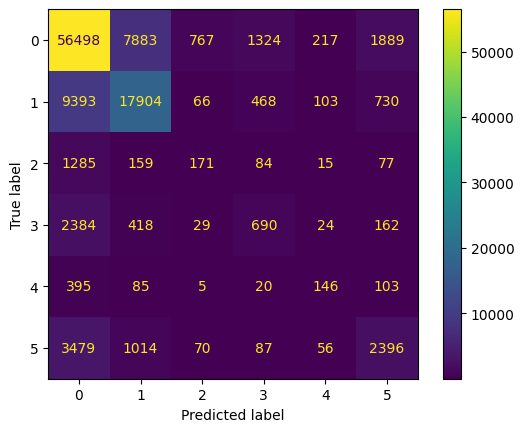

In [12]:
cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cf, display_labels=None)

disp.plot()

## Evaluating Coefficients for Feature Reduction

In [7]:
coefficients = model.coef_

# Get the intercepts for each class
intercepts = model.intercept_

class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame(coefficients, columns=crashes_cleaned.drop(columns = ['CRASH_RECORD_ID', 'Unnamed: 0', 'PRIM_CONTRIBUTORY_CAUSE', 'LONGITUDE', 'LATITUDE', 
                                    'WEATHER_CONDITION_CLEAR', 'ALIGNMENT_STRAIGHT AND LEVEL', 'ROADWAY_SURFACE_COND_SNOW OR SLUSH', 
                                    'ROADWAY_SURFACE_COND_WET', 'ROAD_DEFECT_UNKNOWN', 'MOST_SEVERE_INJURY_NO INDICATION OF INJURY']).columns, index=class_names)

# Display the coefficients
print("Coefficients:")
print(coefficients_df)

# Create a DataFrame to display the intercepts
intercepts_df = pd.DataFrame(intercepts, columns=['Intercept'], index=class_names)

# Display the intercepts
print("\nIntercepts:")
print(intercepts_df)

Coefficients:
         POSTED_SPEED_LIMIT  CRASH_TYPE  INTERSECTION_RELATED_I  \
Class 0           -0.088870    0.584504                0.317777   
Class 1           -0.080839    0.206382                0.479376   
Class 2            0.025308   -0.249143               -0.204654   
Class 3           -0.051125   -0.337411               -0.232819   
Class 4            0.199870   -0.126148               -0.394015   
Class 5           -0.004344   -0.078184                0.034335   

         NOT_RIGHT_OF_WAY_I  HIT_AND_RUN_I    DAMAGE  NUM_UNITS  CRASH_HOUR  \
Class 0            0.070561       0.392142  0.139525   0.205164    0.042188   
Class 1            0.012961       0.253646  0.168819   0.295531    0.049654   
Class 2           -0.014556      -0.550549 -0.065249   0.063378   -0.012580   
Class 3            0.012487       0.725615  0.045151   0.153096   -0.038989   
Class 4           -0.059196      -0.364081 -0.229651  -0.498669   -0.012507   
Class 5           -0.022257      -0.456774

In [9]:
(coefficients_df.max()).max()

2.7846138037494756

In [10]:
threshold = ((coefficients_df.max()).max())/60

col_names = list(coefficients_df.columns[coefficients_df.max() > threshold])

filtered_coef_df = coefficients_df[col_names]
filtered_coef_df

col_names.append('PRIM_CONTRIBUTORY_CAUSE')

crashes_cleaned_2 = crashes_cleaned[col_names]
crashes_cleaned_2

,POSTED_SPEED_LIMIT,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,...,SEC_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"SEC_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",SEC_CONTRIBUTORY_CAUSE_WEATHER,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",MOST_SEVERE_INJURY_INCAPACITATING INJURY,MOST_SEVERE_INJURY_NONINCAPACITATING INJURY,"MOST_SEVERE_INJURY_REPORTED, NOT EVIDENT",PRIM_CONTRIBUTORY_CAUSE
0,30,1,0,0,1,2,4,14,7,7,...,0,0,0,1,0,0,0,0,0,0
1,30,1,0,0,1,2,2,17,3,9,...,0,0,0,1,0,0,0,0,0,0
2,30,0,0,0,0,2,3,18,1,7,...,0,0,0,1,0,0,0,0,0,0
3,30,1,0,0,1,2,2,11,4,9,...,0,0,0,1,0,0,0,0,0,0
4,30,1,1,0,1,2,2,15,7,9,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442377,30,1,0,0,1,0,2,12,4,9,...,0,0,0,1,0,0,0,0,0,0
442378,30,0,0,0,0,2,2,7,3,7,...,0,0,0,1,0,0,0,0,1,3
442379,30,1,0,0,1,2,2,19,7,12,...,0,0,0,0,0,0,0,0,0,0
442380,30,1,0,0,1,1,2,8,5,2,...,0,0,0,1,0,0,0,0,0,1


## Modeling With New Dataset

In [11]:
X2 = crashes_cleaned_2.drop(columns = ['PRIM_CONTRIBUTORY_CAUSE'])
y2 = crashes_cleaned_2['PRIM_CONTRIBUTORY_CAUSE']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
smote2 = SMOTE()
X2_train_resampled, y2_train_resampled = smote2.fit_resample(X2_train, y2_train)
ss2 = StandardScaler()

ss2.fit(X2_train_resampled)

X2_train_scaled = ss2.transform(X2_train_resampled)
X2_test_scaled = ss2.transform(X2_test)


## Fitting New Model

In [13]:
model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

model2.fit(X2_train_scaled, y2_train_resampled)

y2_pred = model2.predict(X2_test_scaled)
accuracy2 = accuracy_score(y2_test, y2_pred)
precision2 = precision_score(y2_test, y2_pred, average=None)
recall2 = recall_score(y2_test, y2_pred, average=None)
f12 = f1_score(y2_test, y2_pred, average=None)
#auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print('Accuracy:', accuracy2)
print('Precision:', precision2)
print('Recall:', recall2)
print('F1 score:', f12)

Accuracy: 0.6840211219212268
Precision: [0.78351729 0.6215026  0.11520302 0.22852807 0.13347237 0.41412811]
Recall: [0.77158302 0.66131135 0.13391877 0.20506536 0.18311874 0.35831315]
F1 score: [0.77750436 0.64078929 0.12385787 0.21616191 0.1544029  0.38420409]


## Confusion Matrix

In [ ]:
cf2 = confusion_matrix(y2_test, y2_pred)
disp2 = ConfusionMatrixDisplay(cf2, display_labels=None)

disp2.plot()

## Modeling on Binned Features

In [20]:
crashes_cleaned_binned = pd.read_csv('../data/crashes_cleaned_binned.csv')
crashes_cleaned_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442382 entries, 0 to 442381
Data columns (total 59 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         442382 non-null  int64  
 1   POSTED_SPEED_LIMIT                                 442382 non-null  int64  
 2   CRASH_TYPE                                         442382 non-null  int64  
 3   INTERSECTION_RELATED_I                             442382 non-null  int64  
 4   NOT_RIGHT_OF_WAY_I                                 442382 non-null  int64  
 5   HIT_AND_RUN_I                                      442382 non-null  int64  
 6   DAMAGE                                             442382 non-null  int64  
 7   PRIM_CONTRIBUTORY_CAUSE                            442382 non-null  int64  
 8   NUM_UNITS                                          442382 non-null  int64 

In [22]:
X = crashes_cleaned_binned.drop(columns = ['PRIM_CONTRIBUTORY_CAUSE'])
y = crashes_cleaned_binned['PRIM_CONTRIBUTORY_CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
ss = StandardScaler()

ss.fit(X_train_resampled)

X_train_scaled = ss.transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

## Fitting Model and Evaluation Metrics

In [23]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

model.fit(X_train_scaled, y_train_resampled)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, log_loss, f1_score, ConfusionMatrixDisplay, roc_auc_score

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
#auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.6866432782379109
Precision: [0.74104701 0.67021651 0.12842466 0.24604052 0.11104061 0.41620714]
Recall: [0.84547523 0.5313285  0.08375209 0.18019962 0.23209549 0.24443819]
F1 score: [0.78982427 0.59274539 0.1013856  0.20803488 0.15021459 0.30799255]


## Confusion Matrix

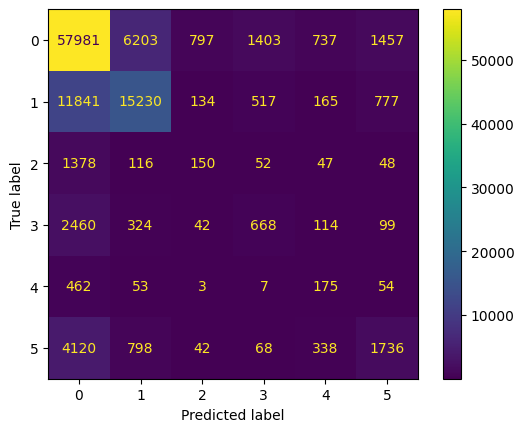

In [24]:
cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cf, display_labels=None)

disp.plot()

# Decision Tree Model

In [25]:
crashes_cleaned = pd.read_csv('../data/crashes_cleaned.csv', index_col = 0)

label = LabelEncoder()

crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'] = label.fit_transform(crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'])
crashes_cleaned

X = crashes_cleaned.drop(columns = ['PRIM_CONTRIBUTORY_CAUSE', 'CRASH_RECORD_ID'])
y = crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

## Fit Model

In [26]:

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

## Cross Validation

In [27]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

def cross_validation(X_train, y_train, num_split=10):
    score_train_list = []
    score_val_list = []

    for train_index, valid_index in KFold(n_splits=num_split).split(X_train):
        # Train and validation splitting
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Create/fit decision tree classifier
        clf = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 39, min_samples_split = 50, random_state =10)
        clf.fit(X_train_fold, y_train_fold)

        # Evaluate performance
        accuracy_train = clf.score(X_train_fold, y_train_fold)
        accuracy_val = clf.score(X_val_fold, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)

    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

result = cross_validation(X_train, y_train, num_split=10)
print(result)

{'train': 0.7455130109233108, 'validation': 0.7353673319107515}


## Plot Decision Tree

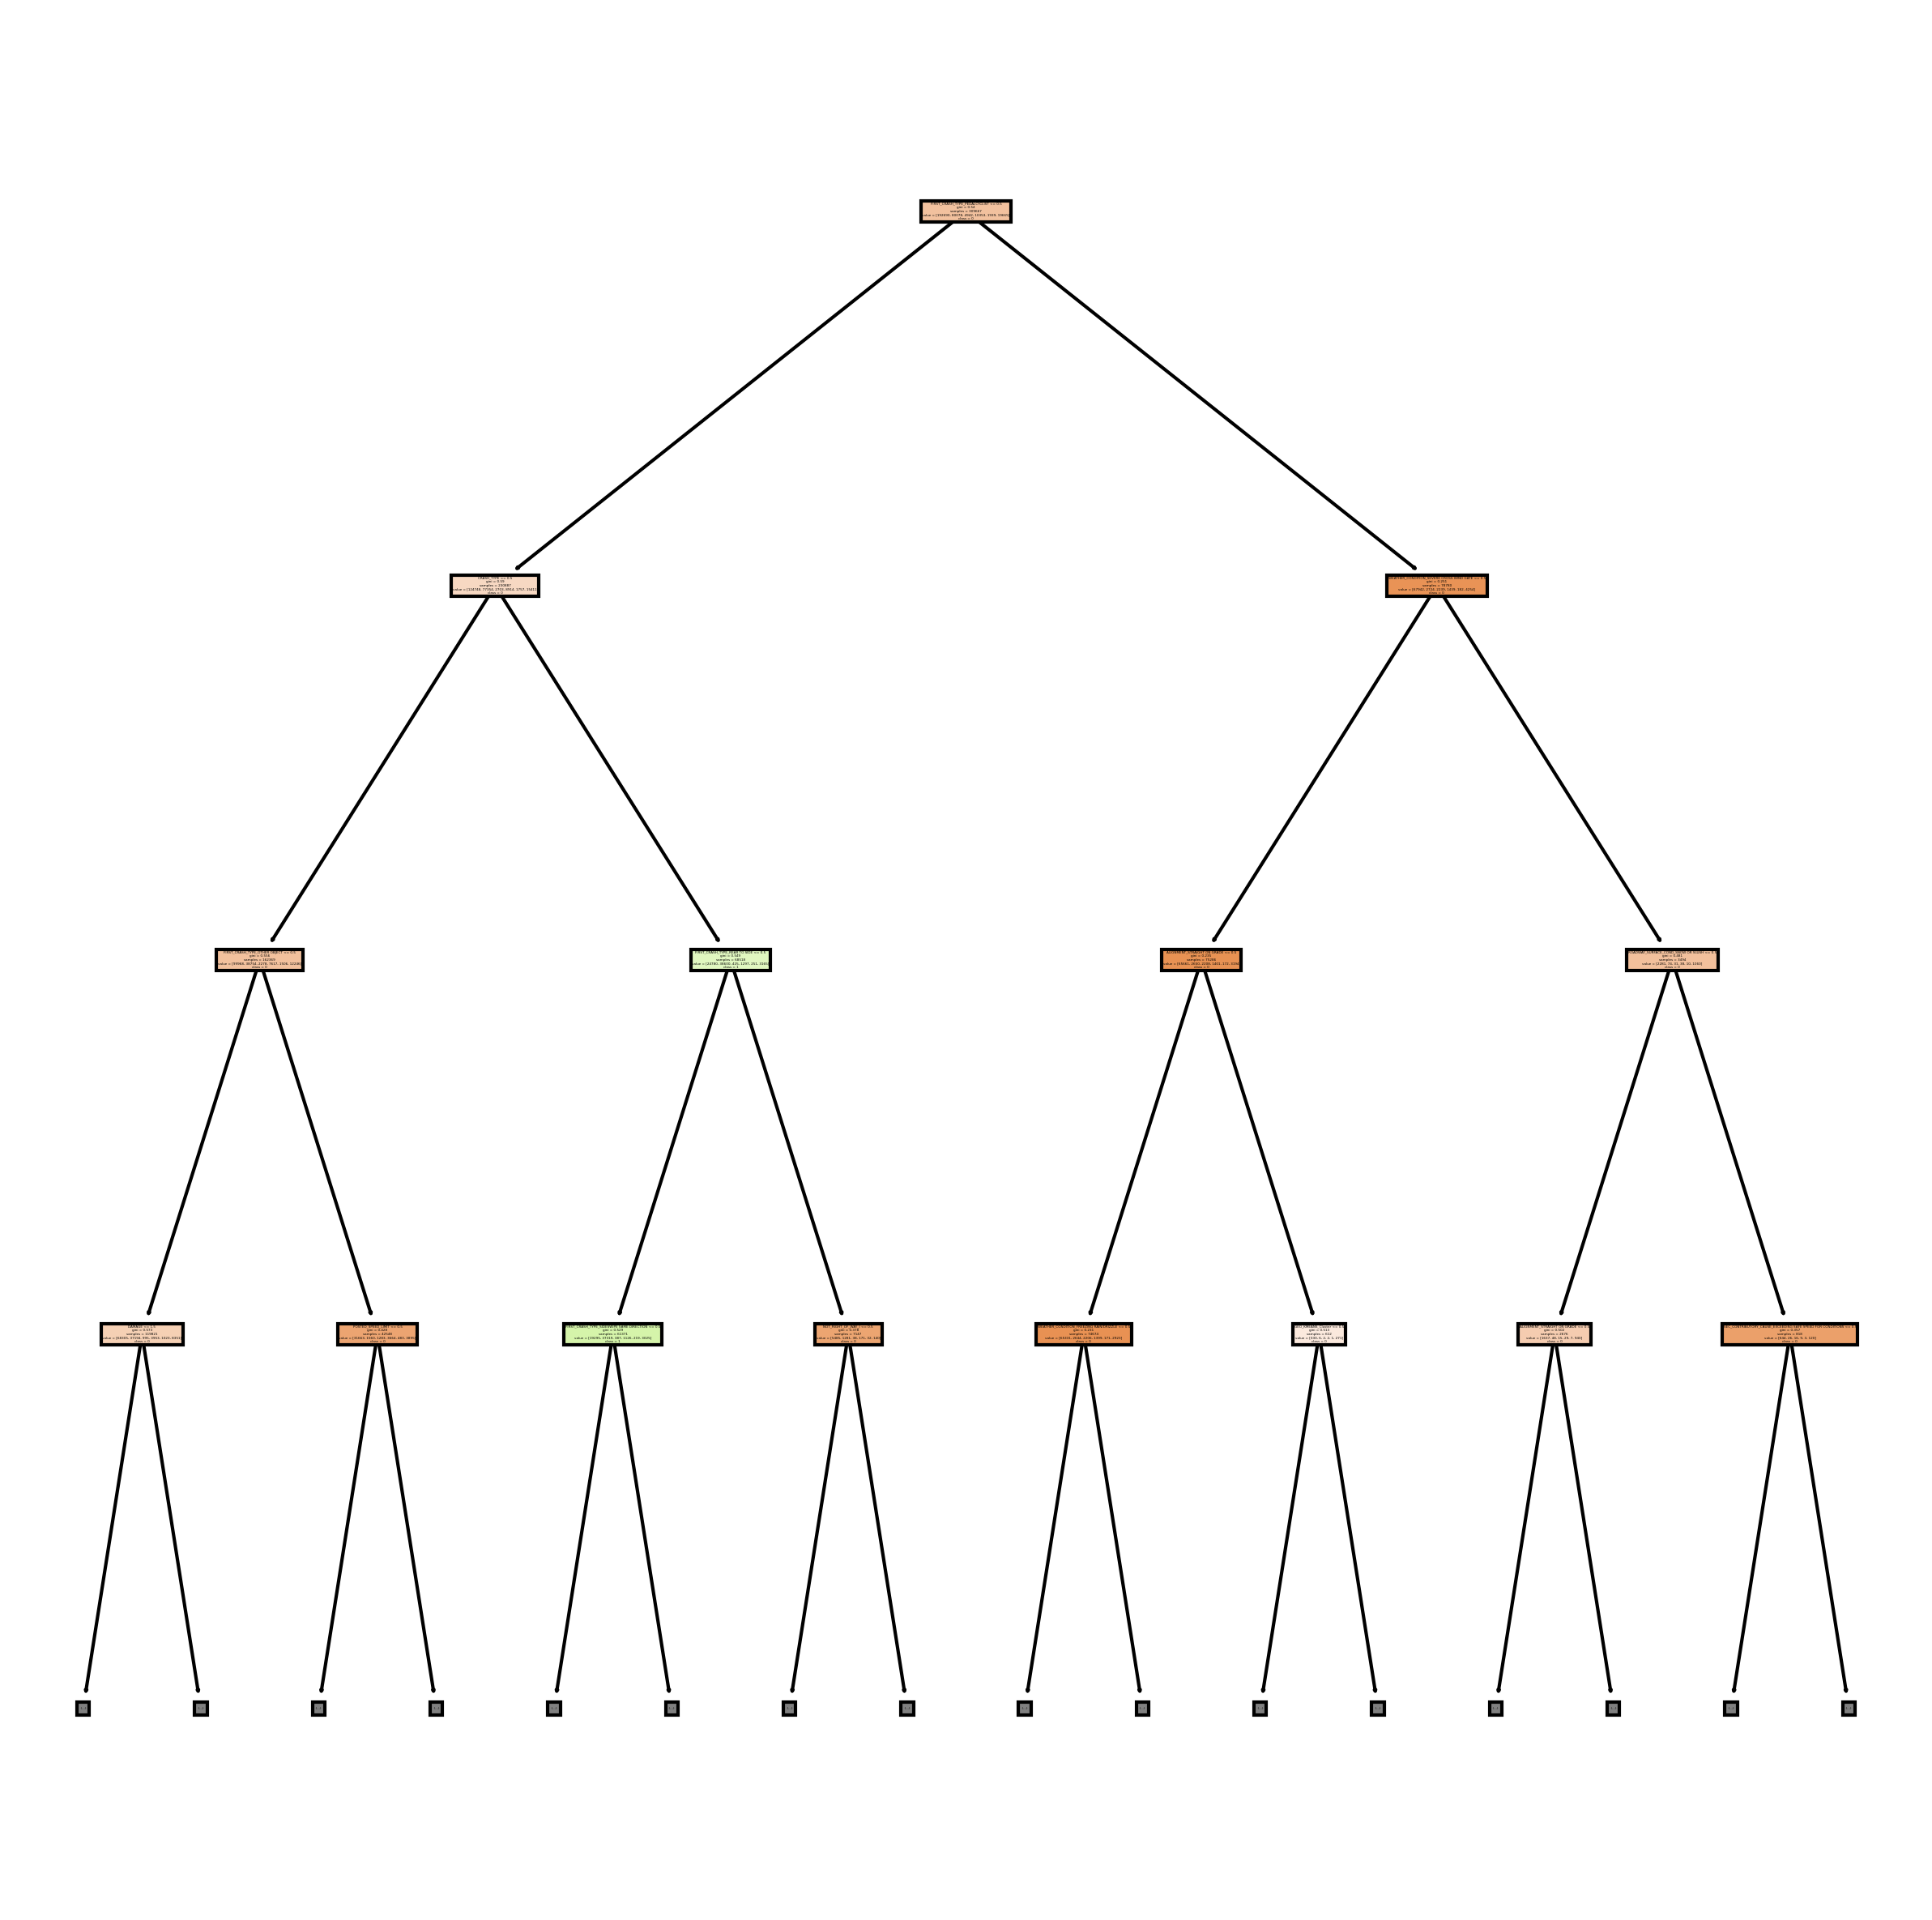

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,10), dpi=300)
plot_tree(clf,
           max_depth = 3,
           feature_names = crashes_cleaned.columns, 
           class_names=np.unique(y).astype('str'),
           filled = True,
           ax = axes)
plt.show()

## Accuracy Score

In [29]:
y_preds = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_preds))

Accuracy: 0.6265380703010209


## Criterion = Entropy

In [31]:
clf_entropy = DecisionTreeClassifier(criterion='entropy')

clf_entropy.fit(X_train, y_train)

y_preds_entropy = clf_entropy.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_preds_entropy))

Accuracy: 0.6284971555589044


## Scaling

In [32]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# try out both models on scaled data
clf.fit(X_train_sc, y_train)
y_preds_sc_gini = clf.predict(X_test_sc)
print('Accuracy gini scaled:', accuracy_score(y_test, y_preds_sc_gini))

clf_entropy.fit(X_train_sc, y_train)
y_preds_sc_entropy = clf_entropy.predict(X_test_sc)
print('Accuracy entropy scaled:', accuracy_score(y_test, y_preds_sc_entropy))

Accuracy gini scaled: 0.626319556945334
Accuracy entropy scaled: 0.6286177146516972


## Balance Weights

In [33]:
clf_w = DecisionTreeClassifier(class_weight='balanced')
clf_w.fit(X_train, y_train)
y_preds_w = clf_w.predict(X_test)
print('Accuracy weighted:', accuracy_score(y_test, y_preds_w))

Accuracy weighted: 0.6219794296047922


## Oversampling with SMOTE

In [34]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


## Model with SMOTE

In [35]:
clf_resamp = DecisionTreeClassifier()

clf_resamp.fit(X_train_resampled, y_train_resampled)

y_preds_resamp = clf_resamp.predict(X_test)
print('Accuracy weighted:', accuracy_score(y_test, y_preds_resamp))

y_pred_proba_resamp = clf_resamp.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba_resamp,  multi_class='ovo')
print('AUC Score:', auc_score)

Accuracy weighted: 0.601966620201183
AUC Score: 0.5959580007170403


## Tuning Hyperparameters

#### Max Depth

In [36]:
depth_list = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for depth in depth_list:
    
    clf_hyper = DecisionTreeClassifier(max_depth = depth, min_samples_split = 10)
    clf_hyper.fit(X_train, y_train)
    y_preds = clf_hyper.predict(X_test)
    print('Accuracy depth', depth,':', accuracy_score(y_test, y_preds))
    
    y_pred_proba = clf.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba,  multi_class='ovo')
    print('AUC Score', depth, ':', auc_score)

Accuracy depth 3 : 0.6802772859134235
AUC Score 3 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 5 : 0.6962136909919753
AUC Score 5 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 7 : 0.7106958520137135
AUC Score 7 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 9 : 0.7262404400406887
AUC Score 9 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 11 : 0.7337678483969408
AUC Score 11 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 13 : 0.7350111140413669
AUC Score 13 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 15 : 0.7337753833402404
AUC Score 15 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 17 : 0.7317258787627623
AUC Score 17 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 19 : 0.7287420412161398
AUC Score 19 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 21 : 0.7244094488188977
AUC Score 21 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


#### Minimum Number of Samples Needed to Split

In [37]:
minsamp_list = [15, 17, 19, 21, 23, 25, 27, 35, 37, 39, 41, 43, 45, 50]

for minsamp in minsamp_list:
    
    clf_hyper = DecisionTreeClassifier(max_depth = 15, min_samples_split = minsamp)
    clf_hyper.fit(X_train, y_train)
    y_preds = clf_hyper.predict(X_test)
    print('Accuracy ', minsamp,':', accuracy_score(y_test, y_preds))
    
y_pred_proba = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba,  multi_class='ovo')
print('AUC Score', minsamp, ':', auc_score)

Accuracy  15 : 0.7341144557887201
Accuracy  17 : 0.7343178992578081
Accuracy  19 : 0.7344761330670987
Accuracy  21 : 0.734672041592887
Accuracy  23 : 0.7349432995516709
Accuracy  25 : 0.7351166032475606
Accuracy  27 : 0.7351542779640583
Accuracy  35 : 0.7354556756960404
AUC Score 35 : 0.47985047270418896


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


#### Minimum Number of Samples Needed in a Leaf

In [38]:
minsamp_list = [37, 39, 41, 43, 45, 50, 100]

for minsamp in minsamp_list:
    
    clf_hyper = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = minsamp, min_samples_split = 50)
    clf_hyper.fit(X_train, y_train)
    y_preds = clf_hyper.predict(X_test)
    print('Accuracy ', minsamp,':', accuracy_score(y_test, y_preds))
    
y_pred_proba = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba,  multi_class='ovo')

Accuracy  37 : 0.7379648118147911
Accuracy  39 : 0.7381456504539803
Accuracy  41 : 0.7382436047168746
Accuracy  43 : 0.73831895414987
Accuracy  45 : 0.7382888143766718
Accuracy  50 : 0.7378216478920996
Accuracy  100 : 0.7367290811136646


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## Combination of Best Hyperparameters

In [39]:
clf_hyper = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 39, min_samples_split = 50)
clf_hyper.fit(X_train, y_train)
y_preds = clf_hyper.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_preds))

Accuracy: 0.7381456504539803


## Final Model Scores

In [40]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

print('Accuracy:', accuracy_score(y_test, y_preds))
print('Precision:', precision_score(y_test, y_preds, average=None))
print('Recall:', recall_score(y_test, y_preds, average=None))
print('f1 score:', f1_score(y_test, y_preds, average=None))

Accuracy: 0.7381456504539803
Precision: [0.76236578 0.67939711 0.57142857 0.52977413 0.83333333 0.63124605]
Recall: [0.88981678 0.64589402 0.01762891 0.05973605 0.10600707 0.23353223]
f1 score: [0.82117543 0.66222209 0.03420265 0.10736579 0.18808777 0.34093432]


## Bagging Classifier

In [41]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=10, max_samples=0.5, max_features=0.5)
bagging.fit(X_train, y_train)
bagging.score(X_test,y_test)

y_pred = bagging.predict(X_test)

print('Accuracy weighted:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average=None))
print('Recall:', recall_score(y_test, y_pred, average=None))
print('f1 score:', f1_score(y_test, y_pred, average=None))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy weighted: 0.6855592811664092
Precision: [0.70769423 0.60889206 0.28947368 0.38433515 0.86956522 0.60639098]
Recall: [0.89049357 0.45211404 0.00484795 0.0488539  0.11778563 0.18872119]
f1 score: [0.78863968 0.51892001 0.00953619 0.08668858 0.20746888 0.2878558 ]


In [42]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 39, min_samples_split = 50, random_state= 15),
                            n_estimators=20, max_samples=0.5, max_features=0.5)
bagging.fit(X_train, y_train)
bagging.score(X_test,y_test)

y_pred = bagging.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.706453678936066
Precision: [0.70963379 0.68591913 0.         1.         0.89285714 0.77294039]
Precision weighted: 0.70612687943881
Recall: [9.32067582e-01 4.53202695e-01 0.00000000e+00 4.63070155e-04
 8.83392226e-02 1.35018135e-01]
Recall weighted: 0.706453678936066
f1 score: [0.80578193 0.54578956 0.         0.00092571 0.1607717  0.22988048]
f1 score weighted: 0.6580164367945258


## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest_list = [20, 30, 40, 50]

for forest_not_tree in forest_list:

    clf = RandomForestClassifier(n_estimators=forest_not_tree, max_depth=None,  min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    clf.score(X_test,y_test)
    y_pred = clf.predict(X_test)
    
    print('-----------------------------------------')
    print('n_estimators', forest_not_tree)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
    print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
    print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
    print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

-----------------------------------------
n_estimators 20
Accuracy: 0.7325999321855103
Precision: [0.75481694 0.67811242 0.39047619 0.47426471 0.82882883 0.63194888]
Precision weighted: 0.7123751029801503
Recall: [0.89198008 0.61941331 0.01806963 0.05973605 0.10836278 0.23142623]
Recall weighted: 0.7325999321855103
f1 score: [0.81768629 0.64743511 0.03454086 0.10610734 0.19166667 0.33878565]
f1 score weighted: 0.702693653696613
-----------------------------------------
n_estimators 30
Accuracy: 0.7366763365105677
Precision: [0.75796152 0.68314721 0.34939759 0.48380952 0.87387387 0.65522985]
Precision weighted: 0.7170208142138466
Recall: [0.89370831 0.63177097 0.01278096 0.05880991 0.11425206 0.23013923]
Recall weighted: 0.7366763365105677
f1 score: [0.82025656 0.65645541 0.02465986 0.10487201 0.20208333 0.34063555]
f1 score weighted: 0.7065827921685637
-----------------------------------------
n_estimators 40
Accuracy: 0.7383415589797687
Precision: [0.75911757 0.68439065 0.37349398 0.5

In [44]:
forest_list = [60,70,80]

for forest_not_tree in forest_list:

    clf = RandomForestClassifier(n_estimators=forest_not_tree, max_depth=None,  min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    clf.score(X_test,y_test)
    y_pred = clf.predict(X_test)
    
    print('-----------------------------------------')
    print('n_estimators', forest_not_tree)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
    print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
    print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
    print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

-----------------------------------------
n_estimators 60
Accuracy: 0.7402328297479561
Precision: [0.76042799 0.68698429 0.44594595 0.5326087  0.86206897 0.67895805]
Precision weighted: 0.7242325904597781
Recall: [0.89583535 0.63936211 0.01454385 0.05672609 0.11778563 0.23481923]
Recall weighted: 0.7402328297479561
f1 score: [0.82259658 0.66231827 0.02816901 0.10253191 0.20725389 0.34895245]
f1 score weighted: 0.7100956777812204
-----------------------------------------
n_estimators 70
Accuracy: 0.7407602757789248
Precision: [0.76056064 0.68788761 0.44736842 0.55606407 0.8487395  0.68306753]
Precision weighted: 0.7255136430605108
Recall: [0.89648796 0.63965634 0.01498457 0.05626302 0.11896349 0.23552124]
Recall weighted: 0.7407602757789248
f1 score: [0.82294926 0.66289582 0.02899787 0.10218671 0.20867769 0.35026971]
f1 score weighted: 0.7105603487151948
-----------------------------------------
n_estimators 80
Accuracy: 0.7408506950985194
Precision: [0.76074916 0.68783387 0.46575342 0.

In [ ]:
forest_list = [90, 100, 110, 120]

for forest_not_tree in forest_list:

    clf = RandomForestClassifier(n_estimators=forest_not_tree, max_depth=None,  min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    clf.score(X_test,y_test)
    y_pred = clf.predict(X_test)
    
    print('-----------------------------------------')
    print('n_estimators', forest_not_tree)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
    print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
    print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
    print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

-----------------------------------------
n_estimators 90
Accuracy: 0.7409938590212108
Precision: [0.76066142 0.68791702 0.5        0.54060325 0.83471074 0.69041096]
Precision weighted: 0.7263638739092805
Recall: [0.89675384 0.64006826 0.01586602 0.05394767 0.11896349 0.23587224]
Recall weighted: 0.7409938590212108
f1 score: [0.82312027 0.66313062 0.03075609 0.09810526 0.20824742 0.35161769]
f1 score weighted: 0.7107083958599655
-----------------------------------------
n_estimators 100
Accuracy: 0.7416569340315714
Precision: [0.76132831 0.68876972 0.55072464 0.55220418 0.83471074 0.68769284]
Precision weighted: 0.7280677423334472
Recall: [0.89688678 0.6424221  0.01674747 0.05510535 0.11896349 0.23470223]
Recall weighted: 0.7416569340315714
f1 score: [0.82356662 0.66478908 0.03250642 0.10021053 0.20824742 0.34996511]
f1 score weighted: 0.7114034054638894
-----------------------------------------
n_estimators 110
Accuracy: 0.7417774931243643
Precision: [0.76141726 0.6891329  0.52173913 

#### Best Number of Estimators Model

In [ ]:
clf = RandomForestClassifier(n_estimators=120, max_depth=None,  min_samples_split=2, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)
y_pred = clf.predict(X_test)

print('-----------------------------------------')
print('n_estimators')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

#### Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

#### ROC-AUC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_scores = clf.predict_proba(X_test)
n_classes = len(clf.classes_)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=clf.classes_)

# Calculate the false positive rate, true positive rate, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()